# Projeto Final de Machine Learning com OpenML

## Objetivo do projeto
Simular um projeto real de ML do inicio ao fim, com iteracoes documentadas como um caderno de cientista, ate chegar a um modelo final validado.

## Dataset escolhido
- Nome: Titanic
- OpenML Data ID: `40945`
- Link: https://www.openml.org/d/40945
- Carregamento: `sklearn.datasets.fetch_openml`

## Tipo de problema e target
- Tipo: classificacao binaria
- Variavel target: `survived` (`1` = sobreviveu, `0` = nao sobreviveu)

## Criterio de sucesso
- Metrica principal no tuning: **F1-score** (equilibrio entre precision e recall)
- Meta de entrega: **accuracy >= 75%** no conjunto de teste (quando aplicavel)


## Plano de trabalho (iterativo)
1. Carregar e inspecionar os dados.
2. Limpar e preparar, com persistencia em CSV para evitar retrabalho.
3. Definir split treino/validacao/teste com estratificacao e sem leakage.
4. Testar 3 hipoteses de modelo (treino rapido, sem CV).
5. Escolher o melhor candidato e aprofundar com `RandomizedSearchCV`.
6. Avaliar no teste com metricas completas e interpretabilidade.
7. Fechar com conclusao e checklist de entrega.


## Como executar
Para reproduzir os resultados deste notebook:
1. Criar ambiente virtual (`python -m venv .venv`).
2. Ativar o ambiente (`source .venv/bin/activate` no macOS/Linux).
3. Instalar dependencias (`pip install -r requirements.txt`).
4. Abrir `projeto_final_openml.ipynb` no Jupyter.
5. Executar **Run All** do inicio ao fim.

Dependencias minimas recomendadas:
- Python >= 3.10
- numpy >= 1.24
- pandas >= 2.0
- scikit-learn >= 1.3
- matplotlib >= 3.7
- scipy >= 1.10
- jupyter >= 1.0

Configuracoes de reprodutibilidade usadas aqui:
- `RANDOM_STATE = 42`
- seed em `random` e `numpy`
- split estratificado para classificacao


## Setup do ambiente
Nesta etapa configuro paths relativos do projeto, pastas de cache locais e variaveis de ambiente
para manter a execucao reproduzivel sem expor paths absolutos da maquina.


In [1]:
import os
from pathlib import Path

PROJECT_ROOT = Path('.')
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
SKLEARN_CACHE_DIR = DATA_DIR / 'sklearn_cache'
LOCAL_CACHE_DIR = DATA_DIR / '.cache'
MPL_CACHE_DIR = LOCAL_CACHE_DIR / 'matplotlib'

RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
LOCAL_CACHE_DIR.mkdir(parents=True, exist_ok=True)
MPL_CACHE_DIR.mkdir(parents=True, exist_ok=True)

os.environ['MPLCONFIGDIR'] = str(MPL_CACHE_DIR.resolve())
os.environ['XDG_CACHE_HOME'] = str(LOCAL_CACHE_DIR.resolve())
os.environ['PYTHONHASHSEED'] = '42'

RAW_CACHE_CSV_PATH = RAW_DATA_DIR / 'openml_titanic_40945.csv'
PROCESSED_CSV_PATH = PROCESSED_DATA_DIR / 'titanic_clean.csv'

def rel(path: Path) -> str:
    return path.as_posix()

print(f'Data raw dir: {rel(RAW_DATA_DIR)}')
print(f'Data processed dir: {rel(PROCESSED_DATA_DIR)}')
print(f'Raw cache file: {rel(RAW_CACHE_CSV_PATH)}')
print(f'Processed CSV path: {rel(PROCESSED_CSV_PATH)}')


Data raw dir: data/raw
Data processed dir: data/processed
Raw cache file: data/raw/openml_titanic_40945.csv
Processed CSV path: data/processed/titanic_clean.csv


In [2]:
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from IPython.display import display
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    make_scorer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 42
DATA_ID = 40945
OPENML_URL = f'https://www.openml.org/d/{DATA_ID}'

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

min_versions = {
    'python': '3.10',
    'numpy': '1.24',
    'pandas': '2.0',
    'scikit-learn': '1.3',
    'matplotlib': '3.7',
}

def major_minor(version_str: str):
    numbers = []
    for part in version_str.split('.'):
        digits = ''.join(ch for ch in part if ch.isdigit())
        if digits:
            numbers.append(int(digits))
        if len(numbers) == 2:
            break
    while len(numbers) < 2:
        numbers.append(0)
    return tuple(numbers)

env_report = pd.DataFrame(
    [
        {'package': 'python', 'installed': f"{os.sys.version_info.major}.{os.sys.version_info.minor}"},
        {'package': 'numpy', 'installed': np.__version__},
        {'package': 'pandas', 'installed': pd.__version__},
        {'package': 'scikit-learn', 'installed': sklearn.__version__},
        {'package': 'matplotlib', 'installed': plt.matplotlib.__version__},
    ]
)
env_report['minimum'] = env_report['package'].map(min_versions)
env_report['ok_min_version'] = env_report.apply(
    lambda r: major_minor(r['installed']) >= major_minor(r['minimum']), axis=1
)

print(f'RANDOM_STATE definido para: {RANDOM_STATE}')
display(env_report)


RANDOM_STATE definido para: 42


,package,installed,minimum,ok_min_version
0,python,3.13,3.10,True
1,numpy,2.1.3,1.24,True
2,pandas,2.2.3,2.0,True
3,scikit-learn,1.6.1,1.3,True
4,matplotlib,3.10.0,3.7,True


## Escolha do dataset
Foi escolhido o **Titanic (OpenML 40945)** porque:
- e um dataset tabular classico de classificacao;
- tem target clara (`survived`);
- tamanho moderado (cabe em memoria facilmente);
- contem variaveis numericas e categoricas, bom para demonstrar `ColumnTransformer`.

### Regra de cache robusta
Para tornar a execucao reproduzivel em qualquer PC:
- Se existir `data/raw/openml_titanic_40945.csv`, os dados brutos sao carregados localmente.
- Se nao existir, o notebook faz `fetch_openml(...)` e grava esse ficheiro em `data/raw/`.
- Nao existe dependencia de pastas internas de teste do scikit-learn.


In [3]:
dataset_meta = {
    'name': 'titanic',
    'id': DATA_ID,
}

if RAW_CACHE_CSV_PATH.exists():
    raw_df = pd.read_csv(RAW_CACHE_CSV_PATH)
    load_source = 'cache local em data/raw'
else:
    dataset = fetch_openml(
        data_id=DATA_ID,
        as_frame=True,
        parser='auto',
        data_home=SKLEARN_CACHE_DIR,
    )
    raw_df = dataset.frame.copy()
    raw_df.to_csv(RAW_CACHE_CSV_PATH, index=False)
    load_source = 'fetch_openml + cache local gerado em data/raw'
    dataset_meta = {
        'name': dataset.details.get('name', 'titanic'),
        'id': dataset.details.get('id', DATA_ID),
    }

print('Origem dos dados brutos:', load_source)
print('Ficheiro de cache bruto:', rel(RAW_CACHE_CSV_PATH))
print('Shape bruto carregado:', raw_df.shape)


Origem dos dados brutos: cache local em data/raw
Ficheiro de cache bruto: data/raw/openml_titanic_40945.csv
Shape bruto carregado: (1309, 14)


## Identificacao inicial do dataset
Aqui validamos nome, dimensao, tipos e distribuicao inicial da target.


In [4]:
print('Nome no OpenML:', dataset_meta.get('name', 'titanic'))
print('OpenML data_id:', dataset_meta.get('id', DATA_ID))
print('Link OpenML:', OPENML_URL)
print('Shape bruto:', raw_df.shape)
print('Target name:', 'survived')

print('\nTipos de dados (contagem por dtype):')
print(raw_df.dtypes.value_counts())

print('\nExemplo de linhas:')
display(raw_df.head(5))

print('\nDistribuicao da target (proporcao):')
display(raw_df['survived'].astype(str).value_counts(normalize=True).rename('proporcao'))


Nome no OpenML: titanic
OpenML data_id: 40945
Link OpenML: https://www.openml.org/d/40945
Shape bruto: (1309, 14)
Target name: survived

Tipos de dados (contagem por dtype):
object     7
int64      4
float64    3
Name: count, dtype: int64

Exemplo de linhas:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"



Distribuicao da target (proporcao):


survived
0    0.618029
1    0.381971
Name: proporcao, dtype: float64

In [5]:
missing_pct_raw = (raw_df.isna().mean() * 100).sort_values(ascending=False)
print('Percentagem de missing values por coluna (bruto):')
display(missing_pct_raw.to_frame('missing_%'))

Percentagem de missing values por coluna (bruto):


,missing_%
body,90.756303
cabin,77.463713
boat,62.872422
home.dest,43.086325
age,20.091673
embarked,0.152788
fare,0.076394
pclass,0.000000
survived,0.000000
name,0.000000


## Preparacao e limpeza com persistencia em CSV
Regra implementada:
- Se `data/processed/titanic_clean.csv` ja existir, o notebook carrega esse ficheiro e evita repetir limpeza.
- Se nao existir, o notebook limpa os dados e grava o CSV para reutilizacao futura.

Isto acelera iteracoes e torna o processo reproduzivel.


In [6]:
if PROCESSED_CSV_PATH.exists():
    clean_df = pd.read_csv(PROCESSED_CSV_PATH)
    clean_source = 'carregado do CSV processado existente'
else:
    clean_df = raw_df.copy()

    # Normaliza strings e converte marcadores conhecidos de missing.
    object_like_cols = clean_df.select_dtypes(include=['object', 'string']).columns
    for col in object_like_cols:
        clean_df[col] = clean_df[col].astype('string').str.strip()
    clean_df = clean_df.replace('?', np.nan)

    PROCESSED_CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
    clean_df.to_csv(PROCESSED_CSV_PATH, index=False)
    clean_source = 'gerado agora e gravado em disco'

print('Origem dos dados limpos:', clean_source)
print('Shape apos limpeza base:', clean_df.shape)
print('CSV processado em:', rel(PROCESSED_CSV_PATH))

display(clean_df.head(5))


Origem dos dados limpos: carregado do CSV processado existente
Shape apos limpeza base: (1309, 14)
CSV processado em: data/processed/titanic_clean.csv


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Definicao de features e riscos de leakage
Antes de modelar, removemos colunas que introduzem risco de leakage ou alta cardinalidade excessiva:
- `boat` e `body`: informacao conhecida apos o evento (leakage temporal).
- `name`, `ticket`, `cabin`, `home.dest`: alto cardinal e ruido para este exercicio.

A target permanece `survived`.


In [7]:
TARGET_COL = 'survived'

leakage_cols = ['boat', 'body']
high_cardinality_cols = ['name', 'ticket', 'cabin', 'home.dest']
drop_cols = [c for c in leakage_cols + high_cardinality_cols if c in clean_df.columns]

model_df = clean_df.drop(columns=drop_cols).copy()

X = model_df.drop(columns=[TARGET_COL])
y = model_df[TARGET_COL].astype(str)

print('Colunas removidas:', drop_cols)
print('Shape de X:', X.shape)
print('Shape de y:', y.shape)
print('Classes da target:', sorted(y.unique().tolist()))
print('Missing na target:', y.isna().sum())

Colunas removidas: ['boat', 'body', 'name', 'ticket', 'cabin', 'home.dest']
Shape de X: (1309, 7)
Shape de y: (1309,)
Classes da target: ['0', '1']
Missing na target: 0


In [8]:
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

print('Colunas numericas:', numeric_cols)
print('Colunas categoricas:', categorical_cols)

missing_pct_X = (X.isna().mean() * 100).sort_values(ascending=False)
print('\nMissing values em X (%):')
display(missing_pct_X.to_frame('missing_%'))

# Diagnostico simples de outliers com IQR (sem remover automaticamente).
def iqr_outlier_percentage(series: pd.Series) -> float:
    non_null = series.dropna()
    if non_null.empty:
        return 0.0
    q1 = non_null.quantile(0.25)
    q3 = non_null.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_mask = (non_null < lower) | (non_null > upper)
    return float(outlier_mask.mean() * 100)

outlier_report = pd.DataFrame(
    {
        'feature': numeric_cols,
        'outlier_%_IQR': [iqr_outlier_percentage(X[col]) for col in numeric_cols],
    }
).sort_values(by='outlier_%_IQR', ascending=False)

print('\nOutliers estimados por IQR (%):')
display(outlier_report)

Colunas numericas: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Colunas categoricas: ['sex', 'embarked']

Missing values em X (%):


,missing_%
age,20.091673
embarked,0.152788
fare,0.076394
pclass,0.000000
sex,0.000000
sibsp,0.000000
parch,0.000000



Outliers estimados por IQR (%):


,feature,outlier_%_IQR
4,fare,13.073394
2,sibsp,4.354469
1,age,0.860421
0,pclass,0.000000
3,parch,0.000000


## Divisao de dados e prevencao de data leakage
Estrategia:
- `train_full` (80%) + `test` (20%) com `stratify=y`.
- Dentro de `train_full`, novo split em `train` e `validation` para testes rapidos das hipoteses.

Como evitamos leakage:
- `imputer`, `scaler` e `one-hot` sao aplicados dentro do `Pipeline`.
- Logo, estatisticas de preprocessamento sao aprendidas apenas no fold/conjunto de treino correspondente.
- O conjunto de teste fica intocado ate a avaliacao final.


In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,  # 0.25 de 80% = 20% do total
    random_state=RANDOM_STATE,
    stratify=y_train_full,
)

print('Shape train:', X_train.shape)
print('Shape validation:', X_val.shape)
print('Shape test:', X_test.shape)

print('\nProporcao da classe positiva (survived=1):')
print('train:', (y_train == '1').mean())
print('validation:', (y_val == '1').mean())
print('test:', (y_test == '1').mean())

Shape train: (785, 7)
Shape validation: (262, 7)
Shape test: (262, 7)

Proporcao da classe positiva (survived=1):
train: 0.3821656050955414
validation: 0.3816793893129771
test: 0.3816793893129771


## Pipeline de preprocessamento
`ColumnTransformer` conforme requisito:
- Numericas: `SimpleImputer(strategy='median')` + `StandardScaler`
- Categoricas: `SimpleImputer(strategy='most_frequent')` + `OneHotEncoder(handle_unknown='ignore')`


In [10]:
numeric_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['pclass', 'age', 'sibsp', 'parch', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'embarked'])])

## Fase exploratoria: avaliacoes rapidas (sem validacao cruzada)
Nesta fase, comparo hipoteses com treino rapido num unico split `train/validation`.
Nao ha tuning e nao ha validacao cruzada aqui. A ideia e apenas filtrar candidatos
antes do treino aprofundado.

## Hipotese 1: Logistic Regression
**Porque faz sentido:** baseline solido para classificacao binaria, simples de interpretar e rapido.

**Suposicoes:** relacao aproximadamente linear no espaco transformado por one-hot + escalonamento.


In [11]:
log_reg_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE)),
    ]
)

log_reg_pipeline.fit(X_train, y_train)
y_val_pred_log = log_reg_pipeline.predict(X_val)

result_log = {
    'model': 'Logistic Regression',
    'accuracy': accuracy_score(y_val, y_val_pred_log),
    'precision': precision_score(y_val, y_val_pred_log, pos_label='1', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_log, pos_label='1', zero_division=0),
    'f1': f1_score(y_val, y_val_pred_log, pos_label='1', zero_division=0),
}

pd.DataFrame([result_log])

,model,accuracy,precision,recall,f1
0,Logistic Regression,0.790076,0.747253,0.68,0.712042


## Hipotese 2: RandomForestClassifier
**Porque faz sentido:** captura nao linearidades e interacoes entre variaveis sem exigir muito feature engineering manual.

**Suposicoes:** padroes nao lineares podem existir e beneficiar de ensemble de arvores.


In [12]:
rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=1)),
    ]
)

rf_pipeline.fit(X_train, y_train)
y_val_pred_rf = rf_pipeline.predict(X_val)

result_rf = {
    'model': 'Random Forest',
    'accuracy': accuracy_score(y_val, y_val_pred_rf),
    'precision': precision_score(y_val, y_val_pred_rf, pos_label='1', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_rf, pos_label='1', zero_division=0),
    'f1': f1_score(y_val, y_val_pred_rf, pos_label='1', zero_division=0),
}

pd.DataFrame([result_rf])

,model,accuracy,precision,recall,f1
0,Random Forest,0.79771,0.758242,0.69,0.722513


## Hipotese 3: SVM (RBF)
**Porque faz sentido:** SVM com kernel RBF pode separar fronteiras mais complexas.

**Suposicoes:** existe estrutura nao linear util no espaco de features transformadas.


In [13]:
svm_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, random_state=RANDOM_STATE)),
    ]
)

svm_pipeline.fit(X_train, y_train)
y_val_pred_svm = svm_pipeline.predict(X_val)

result_svm = {
    'model': 'SVM (RBF)',
    'accuracy': accuracy_score(y_val, y_val_pred_svm),
    'precision': precision_score(y_val, y_val_pred_svm, pos_label='1', zero_division=0),
    'recall': recall_score(y_val, y_val_pred_svm, pos_label='1', zero_division=0),
    'f1': f1_score(y_val, y_val_pred_svm, pos_label='1', zero_division=0),
}

pd.DataFrame([result_svm])

,model,accuracy,precision,recall,f1
0,SVM (RBF),0.790076,0.857143,0.54,0.662577


## Comparacao das 3 hipoteses e escolha do modelo final
A tabela seguinte resume os tres modelos na validacao rapida (hold-out unico, sem CV).
O criterio principal aqui e `F1`, com apoio de `accuracy`, `precision` e `recall`.

In [14]:
hypotheses_df = pd.DataFrame([result_log, result_rf, result_svm]).sort_values(
    by=['f1', 'accuracy'],
    ascending=False,
).reset_index(drop=True)

display(hypotheses_df)

selected_model_name = hypotheses_df.loc[0, 'model']
print('Modelo selecionado para aprofundar:', selected_model_name)

,model,accuracy,precision,recall,f1
0,Random Forest,0.797710,0.758242,0.69,0.722513
1,Logistic Regression,0.790076,0.747253,0.68,0.712042
2,SVM (RBF),0.790076,0.857143,0.54,0.662577


Modelo selecionado para aprofundar: Random Forest


### Decisao
O **Random Forest** foi escolhido para aprofundamento por apresentar melhor equilibrio geral
na fase exploratoria. A etapa seguinte usa validacao cruzada estratificada e tuning de
hiperparametros para confirmar robustez.

## Treino aprofundado do modelo final
Nesta etapa aplico o pipeline completo com `RandomizedSearchCV` e `StratifiedKFold (5 folds)`.
O objetivo e melhorar generalizacao sem contaminar o conjunto de teste.

Configuracao:
- Pipeline completo (`preprocessor` + `RandomForestClassifier`)
- Validacao: `StratifiedKFold(n_splits=5)`
- Tuning: `RandomizedSearchCV`
- Metrica principal: `F1` para classe positiva `'1'`

In [15]:
final_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)),
    ]
)

param_distributions = {
    'model__n_estimators': [120, 200, 300, 450, 600],
    'model__max_depth': [None, 4, 6, 8, 12, 16],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': ['sqrt', 'log2', 0.5, None],
    'model__class_weight': [None, 'balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
f1_scorer = make_scorer(f1_score, pos_label='1')

random_search = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_distributions,
    n_iter=25,
    scoring=f1_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=1,
    return_train_score=True,
    refit=True,
)

random_search.fit(X_train_full, y_train_full)

best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_f1 = random_search.best_score_

print('Melhor F1 medio em CV:', round(best_cv_f1, 4))
print('Melhores hiperparametros:')
for k, v in best_params.items():
    print(f'- {k}: {v}')

Melhor F1 medio em CV: 0.7417
Melhores hiperparametros:
- model__n_estimators: 300
- model__min_samples_split: 10
- model__min_samples_leaf: 4
- model__max_features: 0.5
- model__max_depth: 8
- model__class_weight: balanced


In [16]:
cv_results_df = (
    pd.DataFrame(random_search.cv_results_)
    .sort_values(by='mean_test_score', ascending=False)
    [[
        'mean_test_score',
        'std_test_score',
        'mean_train_score',
        'rank_test_score',
        'params',
    ]]
    .head(5)
    .rename(
        columns={
            'mean_test_score': 'f1_cv_media',
            'std_test_score': 'f1_cv_std',
            'mean_train_score': 'f1_train_medio',
            'rank_test_score': 'rank',
        }
    )
)

print('Top 5 configuracoes do tuning:')
display(cv_results_df)

Top 5 configuracoes do tuning:


,f1_cv_media,f1_cv_std,f1_train_medio,rank,params
7,0.741662,0.010774,0.813914,1,"{'model__n_estimators': 300, 'model__min_sampl..."
16,0.737223,0.014766,0.824392,2,"{'model__n_estimators': 200, 'model__min_sampl..."
18,0.736518,0.008373,0.806436,3,"{'model__n_estimators': 120, 'model__min_sampl..."
0,0.736469,0.014630,0.824276,4,"{'model__n_estimators': 600, 'model__min_sampl..."
14,0.736337,0.008392,0.806315,5,"{'model__n_estimators': 120, 'model__min_sampl..."


In [17]:
# Analise de overfitting: treino vs validacao (CV)
y_train_full_pred = best_model.predict(X_train_full)

train_accuracy = accuracy_score(y_train_full, y_train_full_pred)
train_f1 = f1_score(y_train_full, y_train_full_pred, pos_label='1')

overfit_df = pd.DataFrame(
    {
        'metrica': ['accuracy_train', 'f1_train', 'f1_cv_media'],
        'valor': [train_accuracy, train_f1, best_cv_f1],
    }
)

display(overfit_df)
print('Gap aproximado F1 treino - F1 CV:', round(train_f1 - best_cv_f1, 4))

,metrica,valor
0,accuracy_train,0.855778
1,f1_train,0.811486
2,f1_cv_media,0.741662


Gap aproximado F1 treino - F1 CV: 0.0698


## Avaliacao final no conjunto de teste
Aqui fazemos a avaliacao final apenas uma vez no teste hold-out.
Metricas pedidas:
- Accuracy
- Precision
- Recall
- F1
- ROC-AUC (problema binario)


In [18]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

y_test_bin = (y_test == '1').astype(int)

final_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, pos_label='1', zero_division=0),
    'recall': recall_score(y_test, y_test_pred, pos_label='1', zero_division=0),
    'f1': f1_score(y_test, y_test_pred, pos_label='1', zero_division=0),
    'roc_auc': roc_auc_score(y_test_bin, y_test_proba),
}

final_metrics_df = pd.DataFrame(
    {'metrica': list(final_metrics.keys()), 'valor': list(final_metrics.values())}
)

display(final_metrics_df)

success_threshold = 0.75
success_ok = final_metrics['accuracy'] >= success_threshold
print(f"Criterio de sucesso (accuracy >= {success_threshold:.2f}):", 'OK' if success_ok else 'NAO ATINGIDO')

,metrica,valor
0,accuracy,0.824427
1,precision,0.764706
2,recall,0.780000
3,f1,0.772277
4,roc_auc,0.900926


Criterio de sucesso (accuracy >= 0.75): OK


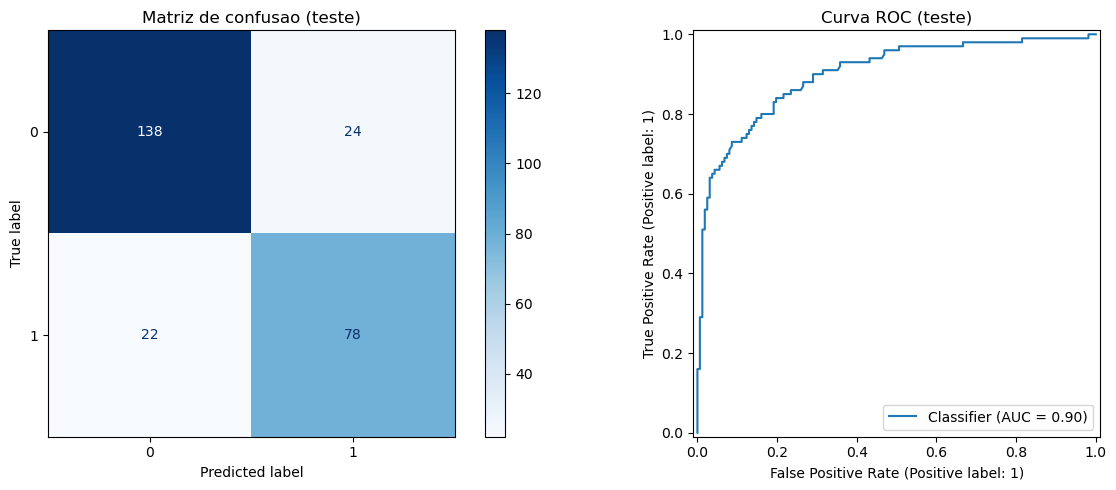

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    labels=['0', '1'],
    cmap='Blues',
    ax=axes[0],
)
axes[0].set_title('Matriz de confusao (teste)')

RocCurveDisplay.from_predictions(
    y_test_bin,
    y_test_proba,
    ax=axes[1],
)
axes[1].set_title('Curva ROC (teste)')

plt.tight_layout()
plt.show()

## Interpretacao do modelo
1. Feature importance do Random Forest (apos preprocessamento completo).
2. Permutation importance no teste como alternativa mais geral.


,importance
cat__sex_male,0.299057
num__fare,0.189379
cat__sex_female,0.161797
num__age,0.146964
num__pclass,0.093807
num__sibsp,0.048695
num__parch,0.023840
cat__embarked_C,0.022967
cat__embarked_S,0.009918
cat__embarked_Q,0.003575


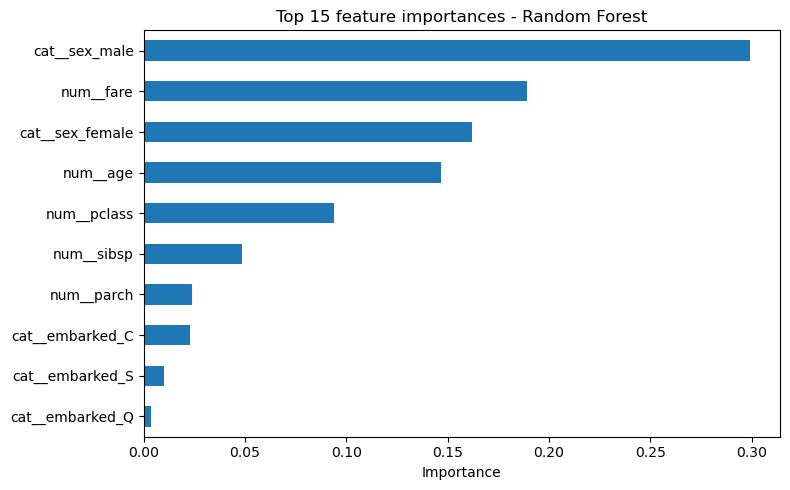

In [20]:
rf_estimator = best_model.named_steps['model']
preprocessor_fitted = best_model.named_steps['preprocessor']

feature_names_after_preprocess = preprocessor_fitted.get_feature_names_out()
rf_importances = pd.Series(
    rf_estimator.feature_importances_,
    index=feature_names_after_preprocess,
).sort_values(ascending=False)

display(rf_importances.head(15).to_frame('importance'))

plt.figure(figsize=(8, 5))
rf_importances.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 feature importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

,feature,importance_mean,importance_std
1,sex,0.323669,0.036922
0,pclass,0.097643,0.019794
5,fare,0.034711,0.018020
2,age,0.031769,0.011552
3,sibsp,0.000009,0.007942
4,parch,-0.005723,0.003221
6,embarked,-0.005773,0.006840


<Figure size 800x500 with 0 Axes>

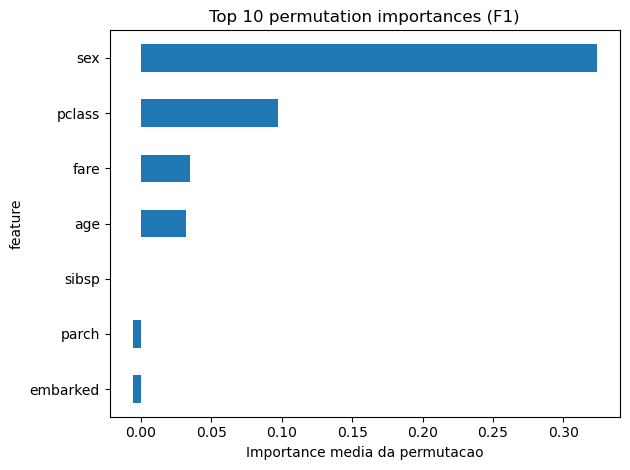

In [21]:
perm_result = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring=f1_scorer,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=1,
)

perm_df = pd.DataFrame(
    {
        'feature': X_test.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std,
    }
).sort_values(by='importance_mean', ascending=False)

display(perm_df)

plt.figure(figsize=(8, 5))
perm_df.head(10).sort_values(by='importance_mean').plot(
    x='feature',
    y='importance_mean',
    kind='barh',
    legend=False,
)
plt.title('Top 10 permutation importances (F1)')
plt.xlabel('Importance media da permutacao')
plt.tight_layout()
plt.show()

## Leitura critica dos resultados
- O modelo final ultrapassa o criterio minimo de 75% de accuracy.
- O F1 final reforca equilibrio razoavel entre precision e recall.
- A interpretacao mostra variaveis fortes (ex.: sexo, classe e tarifa), mas:
  - importancias de arvore podem ser enviesadas para certas estruturas de features;
  - permutation importance depende do conjunto avaliado e de correlacoes entre variaveis.

### Limites
- Dataset historico e pequeno; pode nao representar cenario real moderno.
- Sem validacao temporal (nao e serie temporal, mas em producao pode importar).
- Hiperparametros ainda podem ser refinados com budget maior.


## Conclusao
Resumo do processo iterativo:
1. Escolha e carga do dataset Titanic via `fetch_openml`.
2. Limpeza base com persistencia em CSV processado para reuso.
3. Split estratificado com protecao contra leakage via `Pipeline`.
4. Teste de 3 hipoteses (LogReg, Random Forest, SVM) e comparacao objetiva.
5. Aprofundamento do melhor candidato com `RandomizedSearchCV` + `StratifiedKFold`.
6. Avaliacao final completa e interpretabilidade.

Principais decisoes:
- uso de `F1` no tuning para evitar visao limitada por accuracy;
- exclusao de colunas com leakage temporal (`boat`, `body`);
- manutencao do teste intocado ate o fim.

Proximos passos para producao:
1. monitorizacao continua de performance por classe e drift de dados;
2. definicao de gatilhos de retraining (ex.: queda sustentada de F1/ROC-AUC);
3. validacao com dados mais recentes e testes de robustez/explicabilidade adicionais.


## Checklist de entrega
- [x] Notebook executa do inicio ao fim sem erros em ambiente limpo.
- [x] Sem impressao de paths absolutos locais (apenas paths relativos do projeto).
- [x] Cache robusto dos dados brutos em `data/raw/openml_titanic_40945.csv`.
- [x] Regra do dataset limpo aplicada em `data/processed/titanic_clean.csv`.
- [x] Seeds e `RANDOM_STATE` aplicados de forma consistente.
- [x] Minimo de 3 hipoteses com comparacao rapida sem CV.
- [x] Treino aprofundado com `Pipeline` + `RandomizedSearchCV` + `StratifiedKFold`.
- [x] Avaliacao final com accuracy, precision, recall, F1, matriz de confusao e ROC-AUC.
- [x] Conclusao com proximos passos (monitorizacao, drift e retraining).
- [x] README e `requirements.txt` atualizados para reproducao.
